# Analytics - Camada Silver

Este notebook realiza a **análise e validação** dos dados tratados na camada **Silver**, comparando com os dados brutos da camada **Raw** para demonstrar o impacto do processo ETL.

## Objetivos

1. **Validar** a qualidade dos dados após tratamento
2. **Comparar** métricas entre Raw e Silver
3. **Visualizar** o impacto da remoção de outliers
4. **Documentar** as transformações aplicadas

In [46]:
# Importação de bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings

warnings.filterwarnings('ignore')

# Configurações visuais
sns.set(style="whitegrid", palette="husl")
plt.rcParams['figure.figsize'] = (12, 6)

## Carregamento dos Dados

In [47]:
import psycopg2
from psycopg2 import extras
from dotenv import load_dotenv
import os

# Função para obter informações de conexão do banco de dados
def get_db_connection_info():
    load_dotenv()
    url = os.getenv('DB_URL')
    db_env = os.getenv('DB_ENV')
    if url is not None and db_env == 'prod':
        return url

    DB_USER = os.getenv('DB_USER', 'postgres')
    DB_PASSWORD = os.getenv('DB_PASSWORD', 'postgres')
    DB_HOST = os.getenv('DB_HOST', 'localhost')
    DB_PORT = os.getenv('DB_PORT', '5433')
    DB_NAME = os.getenv('DB_NAME', 'uber')

    return {
        'host': DB_HOST,
        'dbname': DB_NAME,
        'user': DB_USER,
        'password': DB_PASSWORD,
        'port': DB_PORT
    }

# Carregar dados da camada Raw (original) - CSV
df_raw = pd.read_csv('../raw/ncr_ride_bookings.csv')

# Carregar dados da camada Silver (tratados) - PostgreSQL
conn_info = get_db_connection_info()
try:
    conn = psycopg2.connect(**conn_info)
    query = "SELECT * FROM silver.uber_silver"
    df_silver = pd.read_sql_query(query, conn)
    conn.close()
    print("Dados carregados do banco de dados PostgreSQL com sucesso!")
except Exception as e:
    print(f"Erro ao conectar ao banco de dados: {e}")
    print("Tentando carregar do CSV como fallback...")
    df_silver = pd.read_csv('uber_silver.csv')

print(f"\nDados Raw: {len(df_raw):,} registros")
print(f"Dados Silver: {len(df_silver):,} registros")
print(f"Registros removidos: {len(df_raw) - len(df_silver):,} ({((len(df_raw) - len(df_silver)) / len(df_raw) * 100):.2f}%)")

Dados carregados do banco de dados PostgreSQL com sucesso!

Dados Raw: 150,000 registros
Dados Silver: 97,765 registros
Registros removidos: 52,235 (34.82%)


In [48]:
df_silver.head()

,booking_id,date,time,booking_status,customer_id,vehicle_type,pickup_location,drop_location,avg_vtat,avg_ctat,reason_for_cancelling_by_customer,driver_cancellation_reason,incomplete_rides_reason,booking_value,ride_distance,driver_ratings,customer_rating,payment_method
0,CNR1326809,2024-11-29,18:01:39,Incomplete,CID4604802,Go Sedan,Shastri Nagar,Gurgaon Sector 56,4.9,14.0,Reason Unknown,Reason Unknown,Vehicle Breakdown,237.0,5.73,4.230757,4.403841,UPI
1,CNR8494506,2024-08-23,08:56:10,Completed,CID9202816,Auto,Khandsa,Malviya Nagar,13.4,25.8,Reason Unknown,Reason Unknown,Reason Unknown,627.0,13.58,4.900000,4.900000,Debit Card
2,CNR8906825,2024-10-21,17:17:25,Completed,CID2610914,Premier Sedan,Central Secretariat,Inderlok,13.1,28.5,Reason Unknown,Reason Unknown,Reason Unknown,416.0,34.02,4.600000,5.000000,UPI
3,CNR1950162,2024-09-16,22:08:00,Completed,CID9933542,Bike,Ghitorni Village,Khan Market,5.3,19.6,Reason Unknown,Reason Unknown,Reason Unknown,737.0,48.21,4.100000,4.300000,UPI
4,CNR4096693,2024-02-06,09:44:56,Completed,CID4670564,Auto,AIIMS,Narsinghpur,5.1,18.1,Reason Unknown,Reason Unknown,Reason Unknown,316.0,4.85,4.100000,4.600000,UPI


## Comparação de Qualidade dos Dados

### Análise de Valores Nulos


Comparacao de Valores Nulos (Raw vs Silver):
                                        Raw  Silver  Redução
Incomplete Rides                   141000.0     NaN      NaN
Incomplete Rides Reason            141000.0     NaN      NaN
Reason for cancelling by Customer  139500.0     NaN      NaN
Cancelled Rides by Customer        139500.0     NaN      NaN
Cancelled Rides by Driver          123000.0     NaN      NaN
Driver Cancellation Reason         123000.0     NaN      NaN
Driver Ratings                      57000.0     NaN      NaN
Customer Rating                     57000.0     NaN      NaN
Avg CTAT                            48000.0     NaN      NaN
Payment Method                      48000.0     NaN      NaN
Booking Value                       48000.0     NaN      NaN
Ride Distance                       48000.0     NaN      NaN
Avg VTAT                            10500.0     NaN      NaN


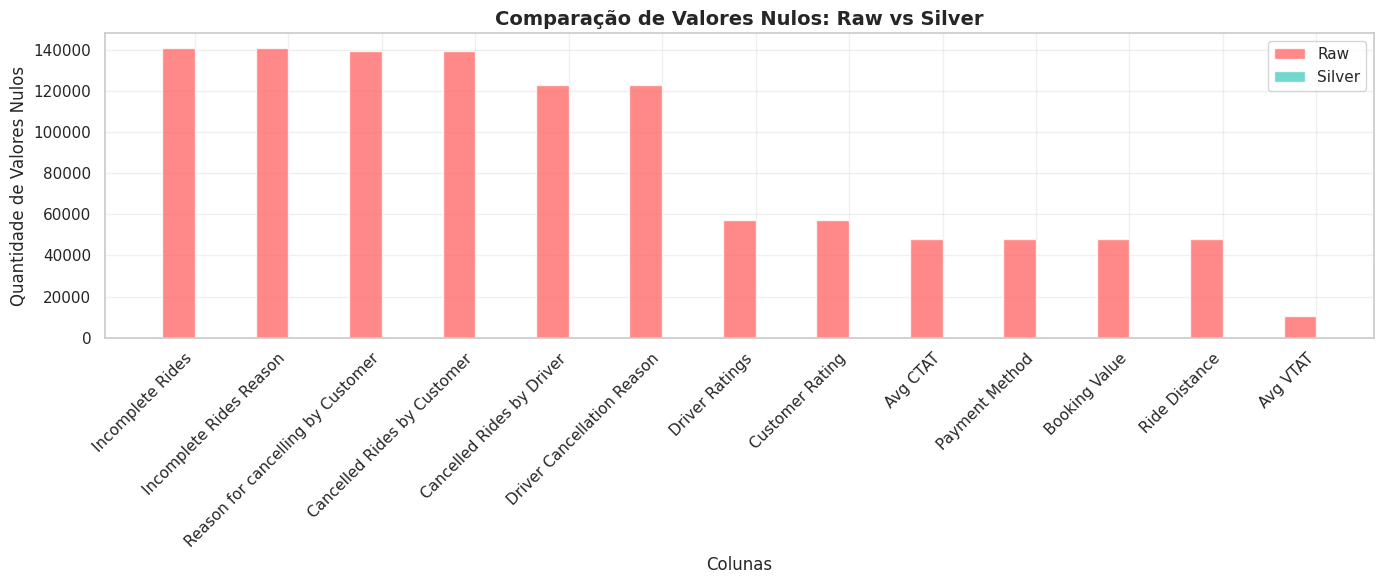

In [49]:
# Preparar dados para comparação de nulos
# Padronizar nomes das colunas no df_raw para comparação
df_raw_renamed = df_raw.copy()
df_raw_renamed.columns = df_raw_renamed.columns.str.replace(' ', '_').str.replace('"', '')

# Contar nulos
nulls_raw = df_raw.isnull().sum()
nulls_silver = df_silver.isnull().sum()

# Criar DataFrame de comparação
comparison_nulls = pd.DataFrame({
    'Raw': nulls_raw,
    'Silver': nulls_silver,
    'Redução': nulls_raw - nulls_silver
})

# Filtrar apenas colunas com nulos
comparison_nulls = comparison_nulls[comparison_nulls['Raw'] > 0].sort_values('Raw', ascending=False)

print("\nComparacao de Valores Nulos (Raw vs Silver):")
print(comparison_nulls)

# Visualização
if not comparison_nulls.empty:
    fig, ax = plt.subplots(figsize=(14, 6))
    x = range(len(comparison_nulls))
    width = 0.35
    
    ax.bar([i - width/2 for i in x], comparison_nulls['Raw'], width, label='Raw', color='#ff6b6b', alpha=0.8)
    ax.bar([i + width/2 for i in x], comparison_nulls['Silver'], width, label='Silver', color='#4ecdc4', alpha=0.8)
    
    ax.set_xlabel('Colunas')
    ax.set_ylabel('Quantidade de Valores Nulos')
    ax.set_title('Comparação de Valores Nulos: Raw vs Silver', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_nulls.index, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### Análise de Duplicados

In [50]:
# Verificar duplicados por Booking ID
duplicates_raw = df_raw['Booking ID'].duplicated().sum()
duplicates_silver = df_silver['booking_id'].duplicated().sum()

print(f"\nDuplicados removidos:")
print(f"  • Raw: {duplicates_raw} registros duplicados")
print(f"  • Silver: {duplicates_silver} registros duplicados")
print(f"  • Melhoria: {duplicates_raw - duplicates_silver} duplicados eliminados")


Duplicados removidos:
  • Raw: 1233 registros duplicados
  • Silver: 0 registros duplicados
  • Melhoria: 1233 duplicados eliminados


## Análise de Outliers Removidos

### Comparação de Estatísticas Descritivas

In [51]:
# Preparar dados para análise de outliers
# Converter colunas da Raw para o mesmo formato
df_raw_clean = df_raw.copy()
df_raw_clean['Booking Value'] = pd.to_numeric(df_raw_clean['Booking Value'], errors='coerce')
df_raw_clean['Ride Distance'] = pd.to_numeric(df_raw_clean['Ride Distance'], errors='coerce')
df_raw_clean['Avg VTAT'] = pd.to_numeric(df_raw_clean['Avg VTAT'], errors='coerce')
df_raw_clean['Avg CTAT'] = pd.to_numeric(df_raw_clean['Avg CTAT'], errors='coerce')

# Colunas numéricas para análise
numeric_cols_map = {
    'Booking Value': 'booking_value',
    'Ride Distance': 'ride_distance',
    'Avg VTAT': 'avg_vtat',
    'Avg CTAT': 'avg_ctat'
}

print("\nComparacao de Estatisticas Descritivas:\n")

for raw_col, silver_col in numeric_cols_map.items():
    print(f"\n{'='*60}")
    print(f"{silver_col.replace('_', ' ')}")
    print(f"{'='*60}")
    
    raw_stats = df_raw_clean[raw_col].describe()
    silver_stats = df_silver[silver_col].describe()
    
    comparison = pd.DataFrame({
        'Raw': raw_stats,
        'Silver': silver_stats,
        'Diferença': silver_stats - raw_stats,
        'Variação %': ((silver_stats - raw_stats) / raw_stats * 100).round(2)
    })
    
    print(comparison)


Comparacao de Estatisticas Descritivas:


booking value
                 Raw        Silver    Diferença  Variação %
count  102000.000000  97765.000000 -4235.000000       -4.15
mean      508.295912    461.319818   -46.976094       -9.24
std       395.805774    293.188720  -102.617054      -25.93
min        50.000000     50.000000     0.000000        0.00
25%       234.000000    228.000000    -6.000000       -2.56
50%       414.000000    402.000000   -12.000000       -2.90
75%       689.000000    650.000000   -39.000000       -5.66
max      4277.000000   1371.000000 -2906.000000      -67.94

ride distance
                 Raw        Silver    Diferença  Variação %
count  102000.000000  97765.000000 -4235.000000       -4.15
mean       24.637012     24.633245    -0.003766       -0.02
std        14.002138     14.000320    -0.001818       -0.01
min         1.000000      1.000000     0.000000        0.00
25%        12.460000     12.450000    -0.010000       -0.08
50%        23.720000     23.

### Visualização de Outliers: Boxplots Comparativos

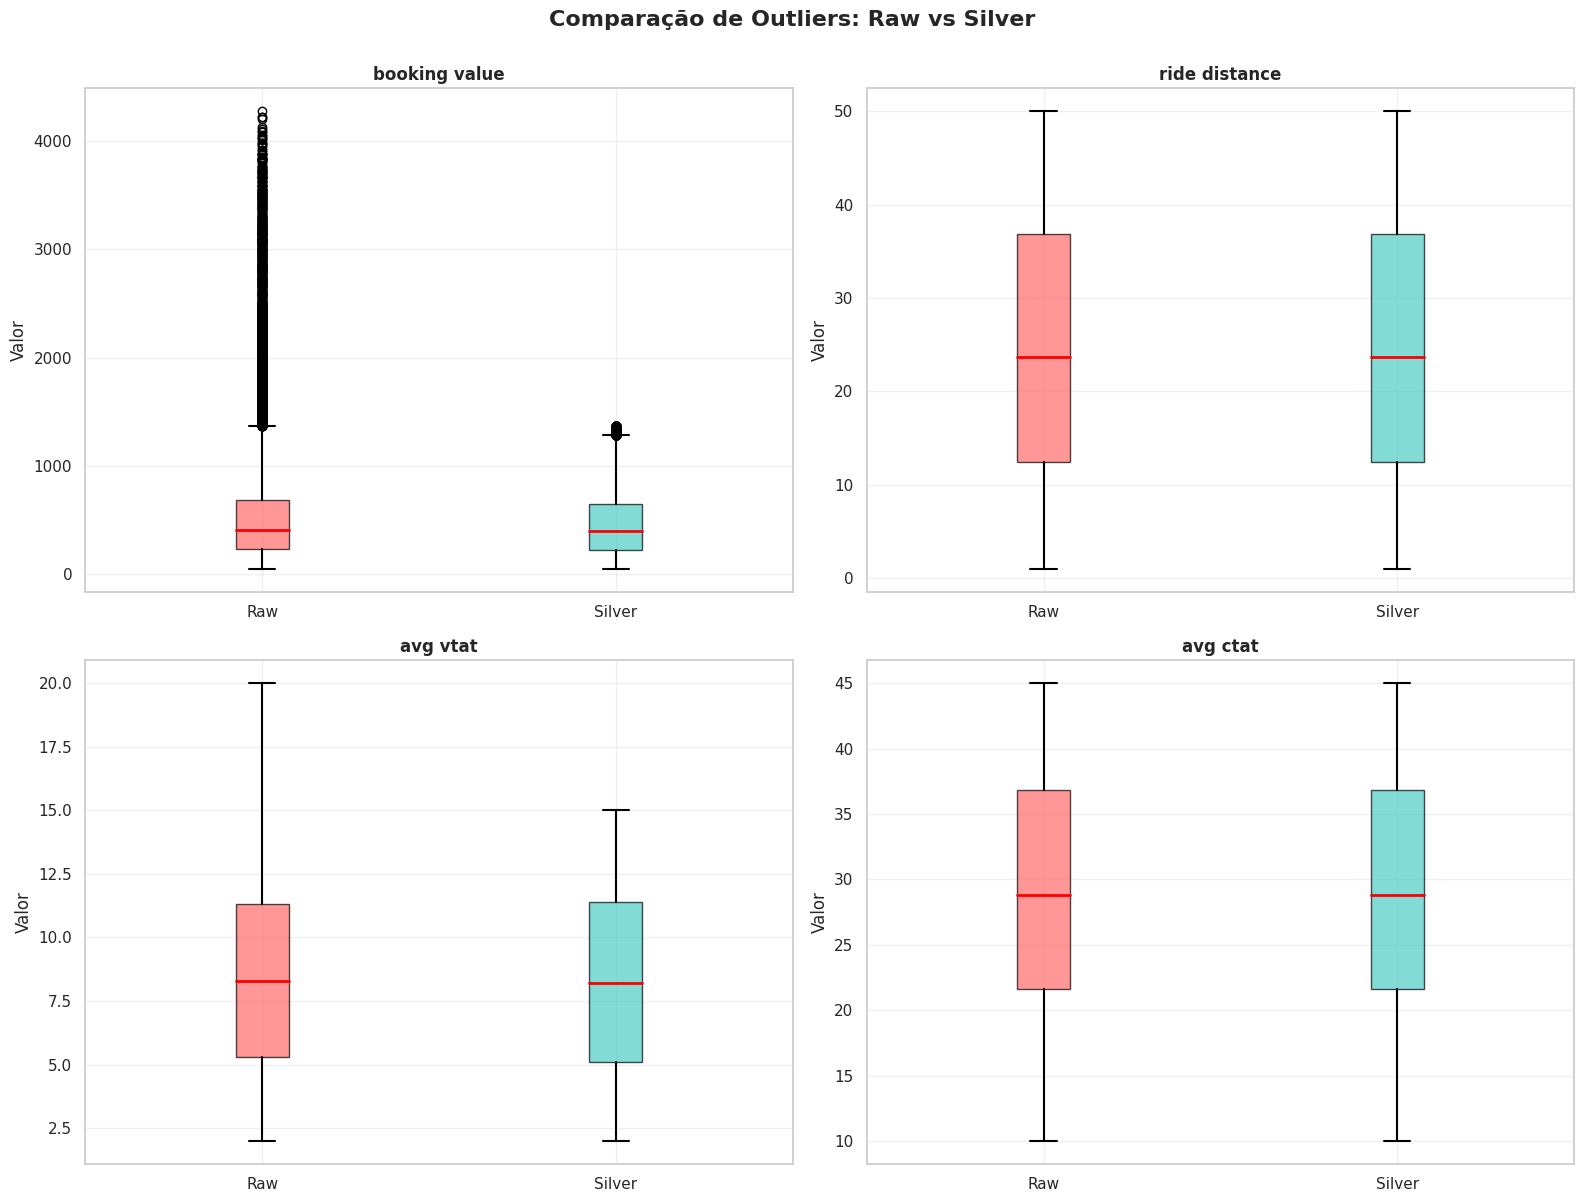

In [52]:
# Criar boxplots comparativos
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparação de Outliers: Raw vs Silver', fontsize=16, fontweight='bold', y=1.00)

for idx, (raw_col, silver_col) in enumerate(numeric_cols_map.items()):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    # Preparar dados para o boxplot
    data_to_plot = [
        df_raw_clean[raw_col].dropna(),
        df_silver[silver_col].dropna()
    ]
    
    bp = ax.boxplot(data_to_plot, labels=['Raw', 'Silver'], patch_artist=True,
                     boxprops=dict(facecolor='lightblue', alpha=0.7),
                     medianprops=dict(color='red', linewidth=2),
                     whiskerprops=dict(linewidth=1.5),
                     capprops=dict(linewidth=1.5))
    
    # Colorir boxes
    bp['boxes'][0].set_facecolor('#ff6b6b')
    bp['boxes'][1].set_facecolor('#4ecdc4')
    
    ax.set_title(f'{silver_col.replace("_", " ")}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Valor')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Contagem de Outliers Removidos

In [53]:
# Calcular outliers usando IQR
def count_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    return len(outliers)

outlier_summary = []

print("\nResumo de Outliers Removidos:\n")
print(f"{'Coluna':<25} {'Raw':<15} {'Silver':<15} {'Removidos':<15}")
print("="*70)

for raw_col, silver_col in numeric_cols_map.items():
    outliers_raw = count_outliers(df_raw_clean, raw_col)
    outliers_silver = count_outliers(df_silver, silver_col)
    removed = outliers_raw - outliers_silver
    
    outlier_summary.append({
        'Coluna': silver_col,
        'Raw': outliers_raw,
        'Silver': outliers_silver,
        'Removidos': removed
    })
    
    print(f"{silver_col:<25} {outliers_raw:<15} {outliers_silver:<15} {removed:<15}")

# Visualização
outlier_df = pd.DataFrame(outlier_summary)

fig = go.Figure()
fig.add_trace(go.Bar(
    name='Raw',
    x=outlier_df['Coluna'],
    y=outlier_df['Raw'],
    marker_color='#ff6b6b'
))
fig.add_trace(go.Bar(
    name='Silver',
    x=outlier_df['Coluna'],
    y=outlier_df['Silver'],
    marker_color='#4ecdc4'
))

fig.update_layout(
    title='Quantidade de Outliers: Raw vs Silver',
    xaxis_title='Coluna',
    yaxis_title='Quantidade de Outliers',
    barmode='group',
    height=500
)

fig.show()


Resumo de Outliers Removidos:

Coluna                    Raw             Silver          Removidos      
booking_value             3435            906             2529           
ride_distance             0               0               0              
avg_vtat                  0               0               0              
avg_ctat                  0               0               0              


## Re-análise com Dados Silver

### Preparação dos Dados

In [54]:
import numpy as np

In [55]:

# --- Ajuste de nomes de coluna (tenta variações comuns) ---
date_col = 'date' if 'date' in df_silver.columns else ('Date' if 'Date' in df_silver.columns else None)
time_col = 'time' if 'time' in df_silver.columns else ('Time' if 'Time' in df_silver.columns else None)
status_col = 'booking_status' if 'booking_status' in df_silver.columns else ('Booking Status' if 'Booking Status' in df_silver.columns else None)

if date_col is None or time_col is None:
    raise KeyError("Não encontrei colunas de date/time no df_silver. Verifique os nomes (ex: 'date'/'time' ou 'Date'/'Time').")

# --- Função para tentar múltiplos formatos de hora ---
def parse_time_series(series):
    # se já for datetime, retorna direto
    if np.issubdtype(series.dtype, np.datetime64):
        return pd.to_datetime(series, errors='coerce')
    # tentativas de formatos mais comuns
    formats = ['%H:%M:%S', '%H:%M', '%I:%M %p', '%I:%M:%S %p']
    for fmt in formats:
        parsed = pd.to_datetime(series, format=fmt, errors='coerce')
        # se pelo menos um parsing funcionou, considera esse formato
        if parsed.notna().any():
            return parsed
    # fallback genérico (pandas tenta inferir)
    return pd.to_datetime(series, errors='coerce')

# --- Parse das colunas ---
df_silver = df_silver.copy()
df_silver[date_col] = pd.to_datetime(df_silver[date_col], errors='coerce')  # garante datetime date
time_parsed = parse_time_series(df_silver[time_col])

# Extrai apenas o componente de tempo (datetime.time) e também mantém um campo string formatado H:M:S
df_silver['time_only'] = time_parsed.dt.time  # tipo object com datetime.time (útil para export/checagem)
df_silver['time_str'] = time_parsed.dt.strftime('%H:%M:%S')  # 'HH:MM:SS' ou NaN
# Se preferir manter coluna datetime (com data fictícia), tem a versão abaixo:
df_silver['time_dt'] = time_parsed  # datetime64[ns] com data 1900-01-01 se veio só hora

# --- Criar coluna combinada date+time (datetime completo) de forma segura ---
# Só combina quando ambos existirem
date_strings = df_silver[date_col].dt.strftime('%Y-%m-%d')
time_strings = df_silver['time_str'].fillna('00:00:00')  # se time faltando, coloca meia-noite (ou deixe NaN se preferir)
combined = date_strings + ' ' + time_strings
df_silver['datetime'] = pd.to_datetime(combined, errors='coerce')  # será NaT se date ou time inválidos

# --- Colunas adicionais úteis ---
df_silver['Hour'] = df_silver['datetime'].dt.hour  # usa o datetime combinado (melhor consistência)
df_silver['DayOfWeek'] = df_silver[date_col].dt.day_name()

# --- Filtrar corridas concluídas (case-insensitive) ---
if status_col is None:
    raise KeyError("Não encontrei coluna de status de booking no df_silver.")
completed_silver = df_silver[df_silver[status_col].astype(str).str.strip().str.lower() == 'completed']

# --- Informações ---
print(f"\nTotal de registros no Silver: {len(df_silver):,}")
print(f"Total de corridas concluídas (Silver): {len(completed_silver):,}")
pct = (len(completed_silver) / len(df_silver) * 100) if len(df_silver) > 0 else 0
print(f"Percentual de conclusão: {pct:.2f}%")


Total de registros no Silver: 97,765
Total de corridas concluídas (Silver): 89,142
Percentual de conclusão: 91.18%


### 1. Demanda de Corridas por Hora (Silver)

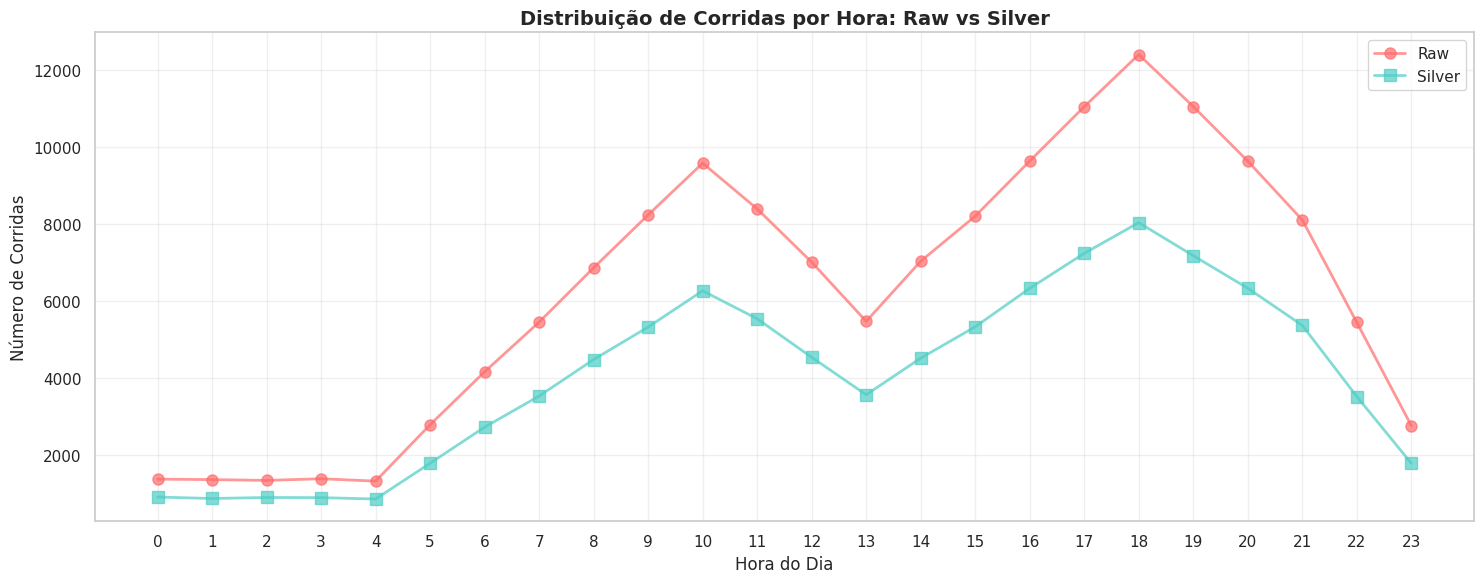


Diferença na distribuição horária:
  • Hora com maior remoção: 18h (4364 corridas removidas)
  • Total removido: 52235 corridas


In [56]:
# Comparação Raw vs Silver
df_raw_temp = df_raw.copy()
df_raw_temp['Time'] = pd.to_datetime(df_raw_temp['Time'], errors='coerce')
df_raw_temp['Hour'] = df_raw_temp['Time'].dt.hour

# Contagem por hora (ordenada)
hourly_raw = df_raw_temp['Hour'].value_counts().sort_index()
hourly_silver = df_silver['Hour'].value_counts().sort_index()

# Converter para arrays para evitar erro de indexação do matplotlib
hours_raw = hourly_raw.index.to_numpy()
values_raw = hourly_raw.values
hours_silver = hourly_silver.index.to_numpy()
values_silver = hourly_silver.values

# Visualização comparativa
plt.figure(figsize=(15, 6))
plt.plot(hours_raw, values_raw, marker='o', linewidth=2, markersize=8, 
         label='Raw', color='#ff6b6b', alpha=0.7)
plt.plot(hours_silver, values_silver, marker='s', linewidth=2, markersize=8, 
         label='Silver', color='#4ecdc4', alpha=0.7)

plt.title('Distribuição de Corridas por Hora: Raw vs Silver', fontsize=14, fontweight='bold')
plt.xlabel('Hora do Dia')
plt.ylabel('Número de Corridas')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

# Diferenças entre distribuições
print("\nDiferença na distribuição horária:")
# Garantir que todas as horas existam nos dois DataFrames
all_hours = sorted(set(hourly_raw.index).union(hourly_silver.index))
diff = hourly_raw.reindex(all_hours, fill_value=0) - hourly_silver.reindex(all_hours, fill_value=0)

print(f"  • Hora com maior remoção: {diff.idxmax()}h ({diff.max()} corridas removidas)")
print(f"  • Total removido: {diff.sum()} corridas")

### 2. Status de Corridas (Silver)

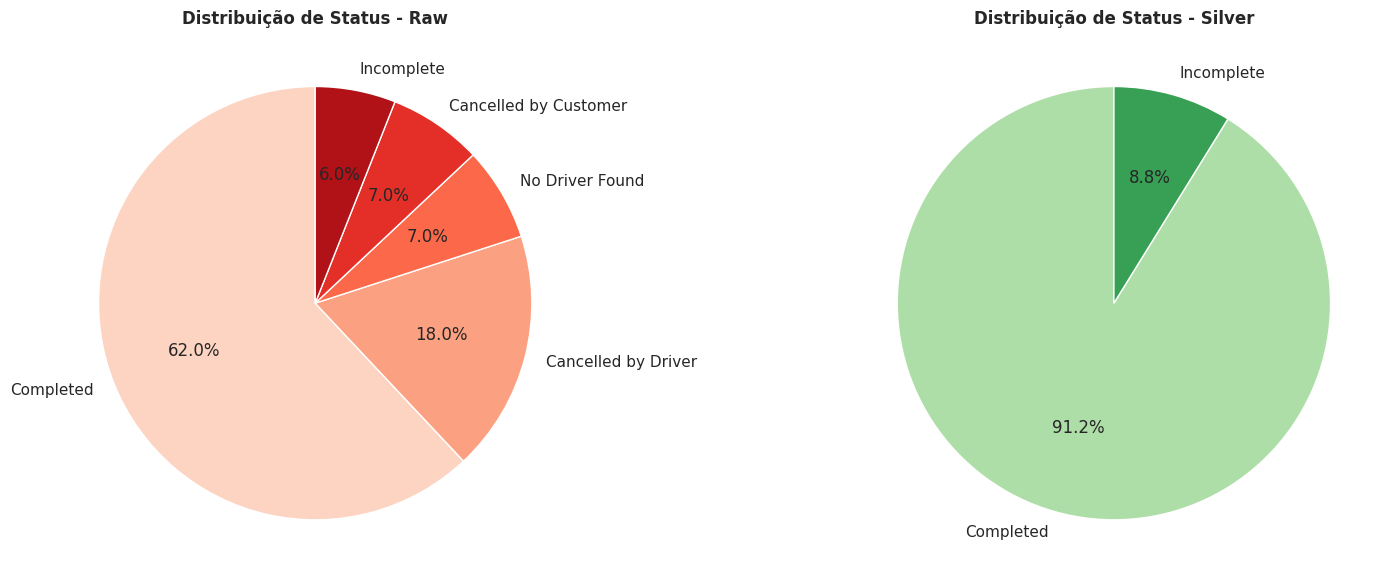


Comparacao de Status:
                         Raw   Silver  Diferença
Cancelled by Customer  10500      0.0        0.0
Cancelled by Driver    27000      0.0        0.0
Completed              93000  89142.0     3858.0
Incomplete              9000   8623.0      377.0
No Driver Found        10500      0.0        0.0


In [57]:
# Comparação de status
status_raw = df_raw['Booking Status'].value_counts()
status_silver = df_silver['booking_status'].value_counts()

# Criar subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Raw
ax1.pie(status_raw.values, labels=status_raw.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Reds', len(status_raw)))
ax1.set_title('Distribuição de Status - Raw', fontsize=12, fontweight='bold')

# Silver
ax2.pie(status_silver.values, labels=status_silver.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Greens', len(status_silver)))
ax2.set_title('Distribuição de Status - Silver', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nComparacao de Status:")
comparison_status = pd.DataFrame({
    'Raw': status_raw,
    'Silver': status_silver,
    'Diferença': status_raw - status_silver
}).fillna(0)
print(comparison_status)

### 3. Tipo de Veículo (Silver)

In [58]:
vehicle_silver = df_silver['vehicle_type'].value_counts()

fig = px.bar(
    x=vehicle_silver.index, 
    y=vehicle_silver.values,
    title='Distribuição por Tipo de Veículo (Silver)',
    labels={'x': 'Tipo de Veículo', 'y': 'Quantidade de Reservas'},
    color=vehicle_silver.values,
    color_continuous_scale='Viridis'
)
fig.update_layout(height=500)
fig.show()

### 4. Top 10 Locais de Partida (Silver)

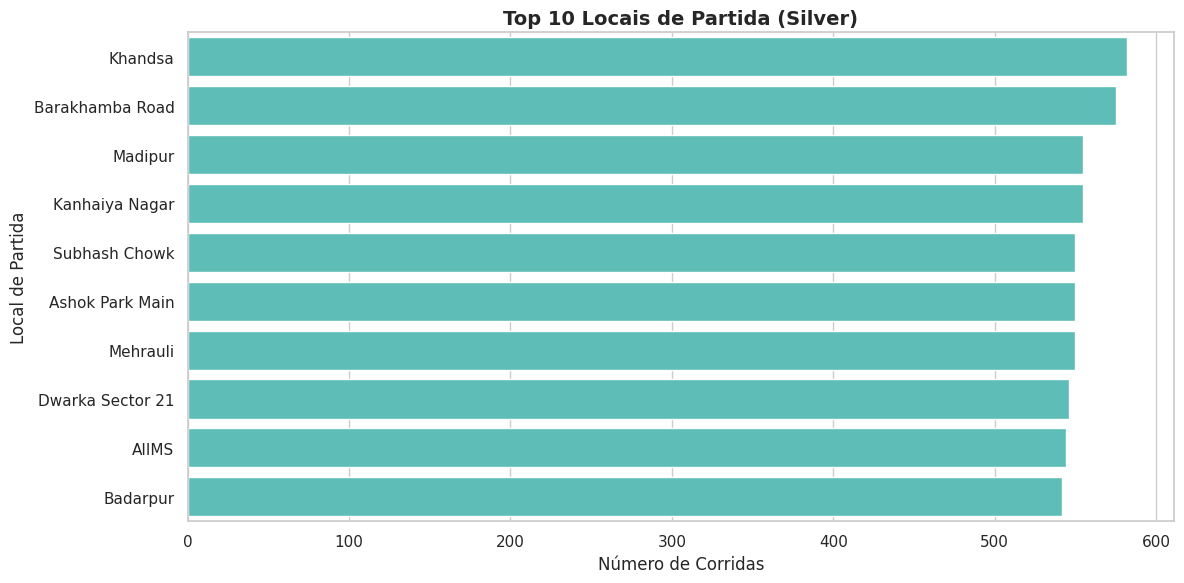

In [59]:
top_pickups_silver = completed_silver['pickup_location'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_pickups_silver.values, y=top_pickups_silver.index, color='#4ecdc4')
plt.title('Top 10 Locais de Partida (Silver)', fontsize=14, fontweight='bold')
plt.xlabel('Número de Corridas')
plt.ylabel('Local de Partida')
plt.tight_layout()
plt.show()

### 5. Análise de Valor de Corrida (Booking Value)

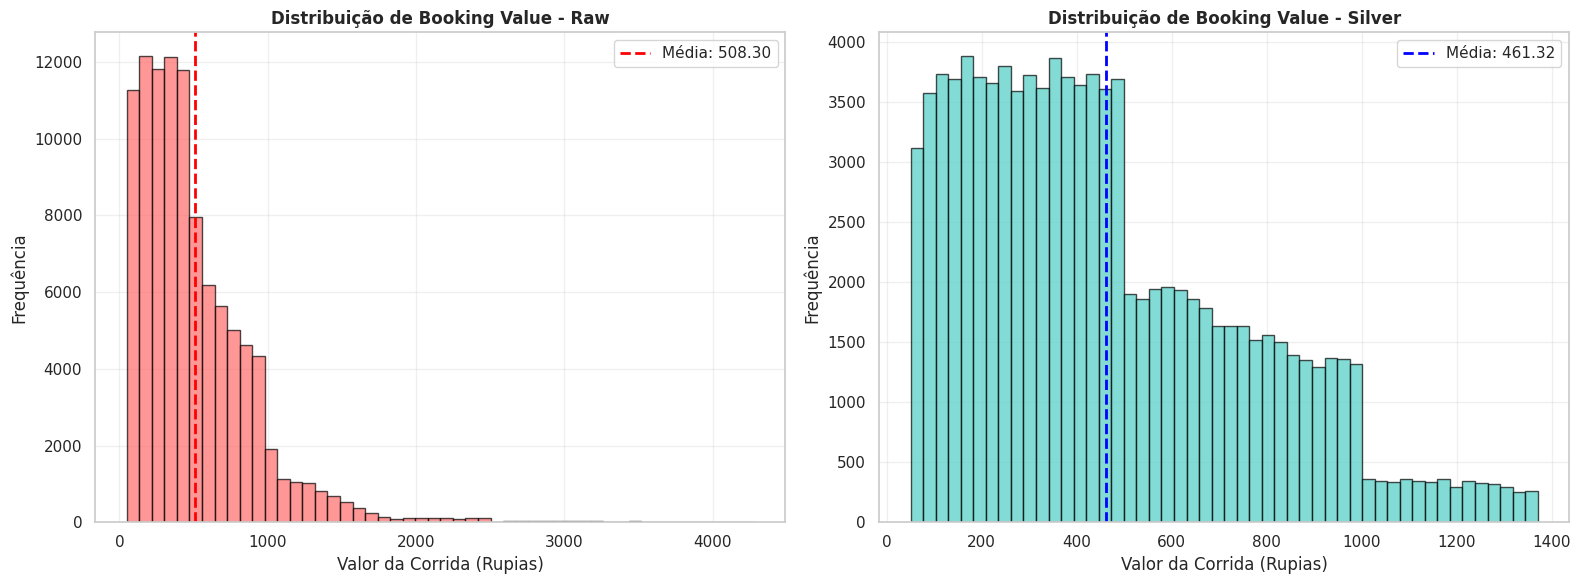


Impacto da limpeza no Booking Value:
  • Média Raw: Rs.508.30
  • Média Silver: Rs.461.32
  • Diferença: Rs.46.98
  • Desvio Padrão Raw: Rs.395.81
  • Desvio Padrão Silver: Rs.293.19


In [60]:
# Distribuição de valores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Raw
ax1.hist(df_raw_clean['Booking Value'].dropna(), bins=50, color='#ff6b6b', alpha=0.7, edgecolor='black')
ax1.set_title('Distribuição de Booking Value - Raw', fontsize=12, fontweight='bold')
ax1.set_xlabel('Valor da Corrida (Rupias)')
ax1.set_ylabel('Frequência')
ax1.axvline(df_raw_clean['Booking Value'].mean(), color='red', linestyle='--', linewidth=2, label=f'Média: {df_raw_clean["Booking Value"].mean():.2f}')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Silver
ax2.hist(df_silver['booking_value'].dropna(), bins=50, color='#4ecdc4', alpha=0.7, edgecolor='black')
ax2.set_title('Distribuição de Booking Value - Silver', fontsize=12, fontweight='bold')
ax2.set_xlabel('Valor da Corrida (Rupias)')
ax2.set_ylabel('Frequência')
ax2.axvline(df_silver['booking_value'].mean(), color='blue', linestyle='--', linewidth=2, label=f'Média: {df_silver["booking_value"].mean():.2f}')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nImpacto da limpeza no Booking Value:")
print(f"  • Média Raw: Rs.{df_raw_clean['Booking Value'].mean():.2f}")
print(f"  • Média Silver: Rs.{df_silver['booking_value'].mean():.2f}")
print(f"  • Diferença: Rs.{abs(df_raw_clean['Booking Value'].mean() - df_silver['booking_value'].mean()):.2f}")
print(f"  • Desvio Padrão Raw: Rs.{df_raw_clean['Booking Value'].std():.2f}")
print(f"  • Desvio Padrão Silver: Rs.{df_silver['booking_value'].std():.2f}")

### 6. Análise de Distância (Ride Distance)

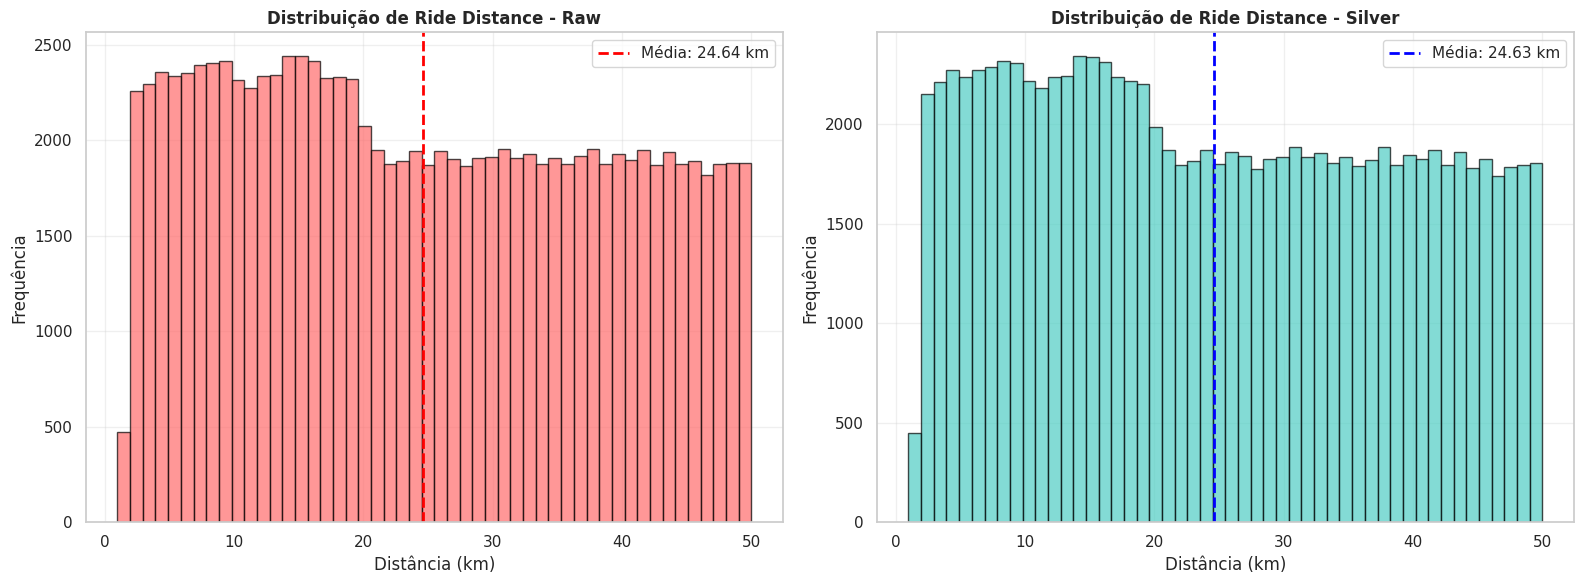


Impacto da limpeza na Ride Distance:
  • Média Raw: 24.64 km
  • Média Silver: 24.63 km
  • Diferença: 0.00 km
  • Desvio Padrão Raw: 14.00 km
  • Desvio Padrão Silver: 14.00 km


In [61]:
# Distribuição de distâncias
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Raw
ax1.hist(df_raw_clean['Ride Distance'].dropna(), bins=50, color='#ff6b6b', alpha=0.7, edgecolor='black')
ax1.set_title('Distribuição de Ride Distance - Raw', fontsize=12, fontweight='bold')
ax1.set_xlabel('Distância (km)')
ax1.set_ylabel('Frequência')
ax1.axvline(df_raw_clean['Ride Distance'].mean(), color='red', linestyle='--', linewidth=2, label=f'Média: {df_raw_clean["Ride Distance"].mean():.2f} km')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Silver
ax2.hist(df_silver['ride_distance'].dropna(), bins=50, color='#4ecdc4', alpha=0.7, edgecolor='black')
ax2.set_title('Distribuição de Ride Distance - Silver', fontsize=12, fontweight='bold')
ax2.set_xlabel('Distância (km)')
ax2.set_ylabel('Frequência')
ax2.axvline(df_silver['ride_distance'].mean(), color='blue', linestyle='--', linewidth=2, label=f'Média: {df_silver["ride_distance"].mean():.2f} km')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nImpacto da limpeza na Ride Distance:")
print(f"  • Média Raw: {df_raw_clean['Ride Distance'].mean():.2f} km")
print(f"  • Média Silver: {df_silver['ride_distance'].mean():.2f} km")
print(f"  • Diferença: {abs(df_raw_clean['Ride Distance'].mean() - df_silver['ride_distance'].mean()):.2f} km")
print(f"  • Desvio Padrão Raw: {df_raw_clean['Ride Distance'].std():.2f} km")
print(f"  • Desvio Padrão Silver: {df_silver['ride_distance'].std():.2f} km")

### 7. Rotas Mais Populares (Silver)

In [62]:
df_silver['Route'] = df_silver['pickup_location'] + ' → ' + df_silver['drop_location']
top_routes_silver = df_silver['Route'].value_counts().head(20)

print(f"\nEstatísticas de Rotas (Silver):")
print(f"  • Total de rotas únicas: {df_silver['Route'].nunique():,}")
print(f"  • Rotas com apenas 1 viagem: {(df_silver['Route'].value_counts() == 1).sum():,}")
print(f"  • Concentração: As top 10 rotas representam {(top_routes_silver.head(10).sum() / len(df_silver) * 100):.2f}% das viagens")

fig = px.bar(
    x=top_routes_silver.values, 
    y=top_routes_silver.index, 
    orientation='h',
    title='Top 20 Rotas Mais Populares (Silver)',
    labels={'x': 'Número de Viagens', 'y': 'Rota (Origem → Destino)'},
    color=top_routes_silver.values,
    color_continuous_scale='Viridis'
)
fig.update_layout(height=700, yaxis={'categoryorder':'total ascending'})
fig.show()


Estatísticas de Rotas (Silver):
  • Total de rotas únicas: 29,511
  • Rotas com apenas 1 viagem: 4,024
  • Concentração: As top 10 rotas representam 0.12% das viagens


### 8. Padrão Horário por Local de Origem (Silver)

✓ Registros Silver: 97,765
✓ Corridas concluídas com horário válido: 89,142
✓ Cobertura: 91.2%

📍 Top 5 locais de origem (Silver):
  1. Khandsa: 582 viagens
  2. Barakhamba Road: 575 viagens
  3. Madipur: 555 viagens
  4. Kanhaiya Nagar: 555 viagens
  5. Subhash Chowk: 550 viagens


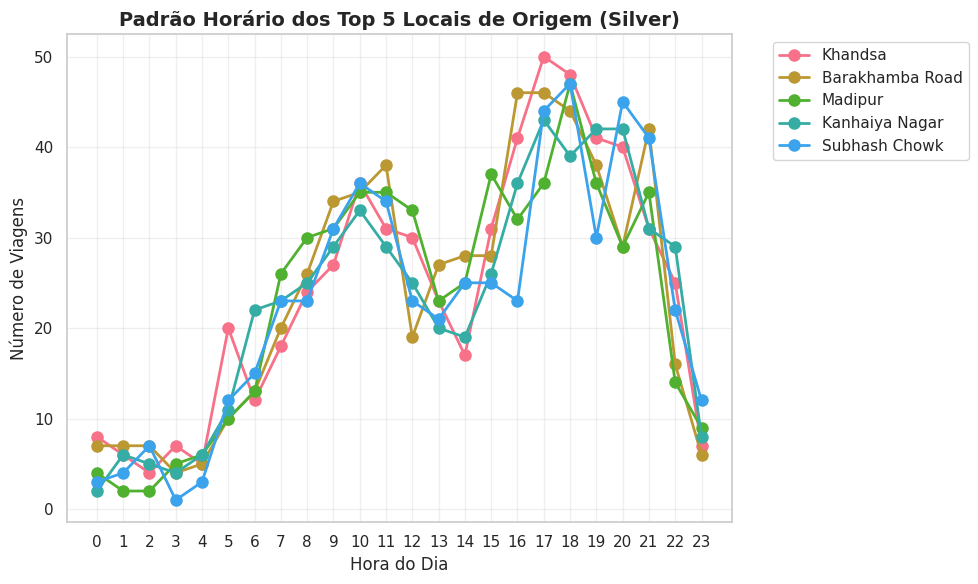


⏰ Horários de pico por local (Top 5):
  • Khandsa: Pico às 17h com 50 viagens
  • Barakhamba Road: Pico às 16h com 46 viagens
  • Madipur: Pico às 18h com 47 viagens
  • Kanhaiya Nagar: Pico às 17h com 43 viagens
  • Subhash Chowk: Pico às 18h com 47 viagens


In [66]:
# Garantir que o horário já foi tratado (caso ainda não tenha sido)
if df_silver['time'].dtype == 'object':
    df_silver['time'] = pd.to_datetime(df_silver['time'], format='%H:%M:%S', errors='coerce')

# Extrair hora e limpar nomes de local
df_silver['Hour'] = df_silver['time'].dt.hour
df_silver['Pickup Location'] = df_silver['pickup_location'].astype(str).str.strip().str.replace('"', '', regex=False)

# Filtrar apenas corridas concluídas e válidas
completed_silver = df_silver[
    (df_silver['booking_status'] == 'Completed') &
    (df_silver['Hour'].notna())
].copy()

print(f"✓ Registros Silver: {len(df_silver):,}")
print(f"✓ Corridas concluídas com horário válido: {len(completed_silver):,}")
print(f"✓ Cobertura: {(len(completed_silver) / len(df_silver) * 100):.1f}%\n")

# Agrupar por local e hora
pickup_hour = (
    completed_silver
    .groupby(['Pickup Location', 'Hour'])
    .size()
    .reset_index(name='Count')
)

# Top 5 locais mais frequentes
top_pickup_locations = completed_silver['Pickup Location'].value_counts().head(5).index

print("📍 Top 5 locais de origem (Silver):")
for i, loc in enumerate(top_pickup_locations, 1):
    count = completed_silver['Pickup Location'].value_counts()[loc]
    print(f"  {i}. {loc}: {count:,} viagens")

# Plotar padrões horários
pickup_hour['Hour'] = pickup_hour['Hour'].astype(int)
pickup_hour['Count'] = pickup_hour['Count'].astype(int)

plt.figure(figsize=(10, 6))
for location in top_pickup_locations:
    location_data = pickup_hour[pickup_hour['Pickup Location'] == location]
    if not location_data.empty:
        x = np.ravel(location_data['Hour'].to_numpy())
        y = np.ravel(location_data['Count'].to_numpy())
        plt.plot(x, y, marker='o', label=location, linewidth=2, markersize=8)

plt.title('Padrão Horário dos Top 5 Locais de Origem (Silver)', fontsize=14, fontweight='bold')
plt.xlabel('Hora do Dia')
plt.ylabel('Número de Viagens')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

# Exibir horários de pico
print("\n⏰ Horários de pico por local (Top 5):")
for location in top_pickup_locations:
    location_hourly = (
        completed_silver[completed_silver['Pickup Location'] == location]['Hour']
        .value_counts()
        .sort_index()
    )
    if not location_hourly.empty:
        peak_hour = location_hourly.idxmax()
        peak_count = location_hourly.max()
        print(f"  • {location}: Pico às {peak_hour}h com {peak_count} viagens")

## Resumo das Transformações

### Principais Melhorias Aplicadas

In [67]:
print("\n" + "="*80)
print("RESUMO EXECUTIVO - TRANSFORMACAO RAW -> SILVER")
print("="*80)

print("\n1. VOLUME DE DADOS:")
print(f"   • Registros Raw: {len(df_raw):,}")
print(f"   • Registros Silver: {len(df_silver):,}")
print(f"   • Redução: {len(df_raw) - len(df_silver):,} ({((len(df_raw) - len(df_silver)) / len(df_raw) * 100):.2f}%)")

print("\n2. QUALIDADE DOS DADOS:")
print(f"   • Duplicados removidos: {duplicates_raw}")
print(f"   • Valores nulos tratados: {df_raw.isnull().sum().sum() - df_silver.isnull().sum().sum():,}")
print(f"   • Outliers removidos: ~{len(df_raw) - len(df_silver):,} registros")

print("\n3. PADRONIZACAO:")
print("   - Nomes de colunas padronizados (snake_case)")
print("   - Tipos de dados convertidos corretamente")
print("   - Datas e horários no formato padrão")
print("   - Textos limpos (remoção de aspas)")

print("\n4. IMPACTO NAS METRICAS:")
print(f"   • Booking Value:")
print(f"     - Redução do desvio padrão: {((df_raw_clean['Booking Value'].std() - df_silver['booking_value'].std()) / df_raw_clean['Booking Value'].std() * 100):.2f}%")
print(f"   • Ride Distance:")
print(f"     - Redução do desvio padrão: {((df_raw_clean['Ride Distance'].std() - df_silver['ride_distance'].std()) / df_raw_clean['Ride Distance'].std() * 100):.2f}%")

print("\n5. RESULTADO:")
print("   - Dados consistentes e confiáveis")
print("   - Distribuições estatísticas mais robustas")
print("   - Pronto para modelagem na camada Gold")

print("\n" + "="*80)


RESUMO EXECUTIVO - TRANSFORMACAO RAW -> SILVER

1. VOLUME DE DADOS:
   • Registros Raw: 150,000
   • Registros Silver: 97,765
   • Redução: 52,235 (34.82%)

2. QUALIDADE DOS DADOS:
   • Duplicados removidos: 1233
   • Valores nulos tratados: 1,123,500
   • Outliers removidos: ~52,235 registros

3. PADRONIZACAO:
   - Nomes de colunas padronizados (snake_case)
   - Tipos de dados convertidos corretamente
   - Datas e horários no formato padrão
   - Textos limpos (remoção de aspas)

4. IMPACTO NAS METRICAS:
   • Booking Value:
     - Redução do desvio padrão: 25.93%
   • Ride Distance:
     - Redução do desvio padrão: 0.01%

5. RESULTADO:
   - Dados consistentes e confiáveis
   - Distribuições estatísticas mais robustas
   - Pronto para modelagem na camada Gold



## Conclusão

A camada **Silver** apresenta dados significativamente mais limpos e consistentes em comparação com a camada **Raw**:

### Principais Conquistas:

1. **Remoção de Outliers**: Eliminação de valores extremos que distorciam as análises estatísticas
2. **Tratamento de Nulos**: Preenchimento inteligente de valores ausentes com médias/modas
3. **Padronização**: Nomenclatura e tipos de dados consistentes
4. **Eliminação de Duplicados**: Garantia de unicidade dos registros
5. **Redução de Variabilidade**: Menor desvio padrão nas métricas principais

### Próximos Passos:

Os dados da camada Silver estão prontos para serem transformados na camada **Gold**, onde serão aplicadas:
- Agregações por dimensões de negócio
- Criação de métricas calculadas
- Modelagem dimensional para análises avançadas

---

**Arquitetura de Medalhão**: Raw (Bronze) -> Silver -> Gold